# In this analysis, we are comparing two things:
- editing sites overlapped with eCLIP peaks
- We want to compare edit sites from one sample (RBFOX2-APOBEC) with respect to the RBFOX2 motif - particularly the distance from the motif (upstream and downstream) against edit sites from another sample (APOBEC-only). We hopefully will see an enrichment when we plot a histogram of distances with respect to the motif. 

# Updated analyses:
### Finds the closest editing sites to peaks with RBFOX2 motif
- start with all peaks: 74902
- filter for peaks in 3'UTR or CDS: 655
- get the peaks with the RBFOX2 motif (GCAUG): 270/655
- for each filtered peak, find the 600 closest editing sites for a window size of 600 
- discard editing sites more than 300nt away and plot position relative to motif
- plot 400bt window so as to make the fitted line not just drop off at the end.
- as a background, compare the distribution of ApoControl edits at/near GCAUG motifs.
- repeat analysis with background and plot differences.

# Re-doing this analysis...
- previously found errors in methodology; previously I was looking at the closest editing sites to each motif (motif contained within a eCLIP peak). However this causes an artifact as the histogram of distances will be biased toward the center. 
- This notebook will perform similar analysis, but will look at ALL sites within a certain window. This window will be determined after looking at how close each motif (within peak) is to each other. I will try and remove overlaps by setting the window (starting at 400nt) such that the least number of windows overlap.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import glob
import pybedtools
import pysam
import re

from Bio import SeqIO

import random
from collections import Counter
from tqdm import tnrange, tqdm_notebook

In [2]:
input_dir = '/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/figure_1/inputs/'
output_dir = '/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/figure_1/outputs/motif_distribution'

# Define the editing sites 
- conf_swap indicates that the "confidence score" should be the 4th column, while the "edit %" should be the 5th column. SAILOR outputs the other way around

In [3]:
editing_sites = os.path.join(input_dir, 'RBFOX2-1000_S20_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted_a0_b0_e0.01.bed')
editing_sites_apobec_only = os.path.join(input_dir, 'ApoControl-1000_S21_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted_a0_b0_e0.01.bed')

# editing_sites = os.path.join(input_dir, 'Sample28_S21_merged.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted_a0_b0_e0.01.bed')
# editing_sites_apobec_only = os.path.join(input_dir, 'Sample14_S13_merged.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted_a0_b0_e0.01.bed')

assert os.path.exists(editing_sites)
assert os.path.exists(editing_sites_apobec_only)

In [4]:
RBFOX2_CONF = 0.9 # 
APOBEC_CONF = 0.9
motif = 'GCATG'
# motif = 'AGTCG' # "negative control"

# find 3'UTR peaks (TODO: multi region parsing)

In [5]:
# Comes from annotating IDR eCLIP peaks using Eric's script (/home/bay001/projects/ryan_editing_20190314/permanent_data/04_annotations/annotate_peaks_bedformat_wproxdistal_lncRNA.pl)
beds = sorted(glob.glob(os.path.join(input_dir, 'EV42_01.basedon_EV42_01.peaks.l2inputnormnew.bed.compressed.bed.annotated')))
beds

['/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/figure_1/inputs/EV42_01.basedon_EV42_01.peaks.l2inputnormnew.bed.compressed.bed.annotated']

### we will just look at RBFOX first.


In [6]:
rbfox2_bed = beds[0]
rbfox2_bed

'/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/figure_1/inputs/EV42_01.basedon_EV42_01.peaks.l2inputnormnew.bed.compressed.bed.annotated'

In [7]:
annotated_headers = [
    'chrom','start','end','l10p','l2fc','strand','region_w_overlap','geneid'
]

def return_region(row):
    """ 
    Based on the way Eric outputs his annotations, let's re-format the region field to make it easier to parse out
    """
    try:
        return row['region_w_overlap'].split('|')[0]
    except IndexError:
        return 'intergenic'

def filter_peaks(df, l10p=3, l2fc=3):
    return df[(df['l10p']>=l10p) & (df['l2fc']>=l2fc)]

peaks = pd.read_table(rbfox2_bed, names=annotated_headers)
print(peaks.shape[0])
peaks['region'] = peaks.apply(return_region, axis=1)
peaks = filter_peaks(peaks)
print(peaks.shape[0])
peaks.head()

/home/bay001/anaconda2/envs/python3-essential/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.


74902
7478


,chrom,start,end,l10p,l2fc,strand,region_w_overlap,geneid,region
0,chr7,99949578,99949663,49.426374,4.618368,+,intron|contained|ENSG00000121716.14,ENSG00000121716.14,intron
1,chr7,76189536,76189625,30.501042,3.761547,+,intron|contained|ENSG00000243566.2,ENSG00000243566.2,intron
2,chr7,891283,891363,27.388043,4.738349,+,intron|contained|ENSG00000164828.13,ENSG00000164828.13,intron
3,chr7,44086401,44086504,25.153471,3.872251,+,intron|contained|ENSG00000136279.14,ENSG00000136279.14,intron
4,chr7,76199656,76199721,23.827660,4.550322,+,intron|contained|ENSG00000243566.2,ENSG00000243566.2,intron


### For at least RBFOX2 STAMP data, we see the vast majority of peaks assigned to 3'UTR. For eCLIP, mostly intronic. However we'll use all peaks with motifs, regardless of their region annotation here.

In [8]:
peaks['region'].value_counts()

intron              6251
3utr                 407
noncoding_intron     307
CDS                  248
noncoding_exon       147
5utr                 118
Name: region, dtype: int64

In [9]:
# peaks = peaks[(peaks['region']=='CDS') | (peaks['region']=='3utr')]
print(peaks.shape[0])

7478


# get the fasta sequences and check for existence of motif
- From each peak, get the (strand-specific) sequence associated with that peak. 
- t -> u
- *APOFOX only* should have 701 peaks with motif TGCATG with no slop (slop is the size of flanking bases on either side of the motif). 
- *APOFOX only* should have 1368 peaks with motif GCATG with no slop

## Define the motif and slop parameters

### Careful - a similar var "window_slop" is defined during window creation below.

In [10]:
slop = 0 # 

In [11]:
chrom_sizes = os.path.join(input_dir, 'hg19.chrom.sizes')

def get_peak_interval_from_annotated_dataframe(df, slop=0, chrom_sizes=None):
    """ 
    Returns a bedtool from a peaks dataframe. 
    Peaks dataframe is basically a df can come from an "eric-annotated" file so as long as it contains the correct fields. 
    """
    bedtool = []
    for row in df.iterrows():
        interval = pybedtools.create_interval_from_list([row[1]['chrom'], int(row[1]['start']), int(row[1]['end']), row[1]['geneid'], "0", row[1]['strand']])
        bedtool.append(interval)
    bedtool = pybedtools.BedTool(bedtool)
    return bedtool.slop(b=slop, genome='hg19')

# utr3_bedtool is a bedtool-ified version of the annotated dataframe for JUST 3'UTR peaks.
bedtool = get_peak_interval_from_annotated_dataframe(peaks, slop=slop, chrom_sizes=chrom_sizes)
bedtool.to_dataframe().head()

/home/bay001/anaconda2/envs/python3-essential/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)


,chrom,start,end,name,score,strand
0,chr7,99949578,99949663,ENSG00000121716.14,0,+
1,chr7,76189536,76189625,ENSG00000243566.2,0,+
2,chr7,891283,891363,ENSG00000164828.13,0,+
3,chr7,44086401,44086504,ENSG00000136279.14,0,+
4,chr7,76199656,76199721,ENSG00000243566.2,0,+


In [12]:
def record_id_to_coords(id_string):
    """ 
    Turns a seqrecord fasta id into coordinates.
    seqrecord fasta ids (stranded) look like this:
    
    chr11:1774028-1774186(-)
    
    """
    chrom, pos = id_string.split(':')
    coord, strand = pos.split('(')
    strand = strand.replace(')','')
    start, end = coord.split('-')
    try:
        assert (strand == '+') or (strand == '-')
    except AssertionError:
        print("Strand not correct: [{}]".format(strand))
        return 1
    return chrom, int(start), int(end), strand

# Get the sequence from peaks and save them

In [13]:
hg19_fasta = os.path.join(input_dir, 'hg19.fa')
bedtool = bedtool.sequence(fi=hg19_fasta, s=True)

# save the temp file
with open(os.path.join(output_dir, 'RBFOX2_peaks.fasta'), 'w') as f:
    f.write(open(bedtool.seqfn).read())

# sanity check - make sure there is a significant portion of peaks that contain the motif.

In [14]:
complement = {
    'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A',
    'a': 't', 'c': 'g', 'g': 'c', 't': 'a'
} 

def reverse_complement(seq):
    """ returns the reverse complement of a sequence. """
    bases = list(seq) 
    bases = reversed([complement.get(base,base) for base in bases])
    bases = ''.join(bases)
    return bases

pos = [] # length will be the number of all peaks; contains positions where a motif was found. 
with open(os.path.join(output_dir, 'RBFOX2_peaks.fasta'), 'r') as f:
    for line in f:
        if line.startswith('>'):
            chrom, start, end, strand = record_id_to_coords(line[1:].rstrip())
        else:
            if strand == '+':
                pos.append(line.upper().find(motif))
            elif strand == '-':
                pos.append(line.upper().find(motif)) # sequence is returned reverse-complemented, so we should be looking for the motif
                # pos.append(line.find(reverse_complement(motif)))
            else:
                print('strand not correct: [{}]'.format(strand))

no_motif_count = 0
motif_count = 0

pos_with_motif = [] # will contain the FIRST position in a read where the motif is found.

for p in pos:
    if p == -1: # can't find motif
        no_motif_count += 1
    else: # motif exists
        motif_count += 1
        pos_with_motif.append(p)
        
print("Peaks with motif: {}. Peaks WITHOUT motif: {}".format(motif_count, no_motif_count))
# Peaks with motif: 429. Peaks WITHOUT motif: 2836

Peaks with motif: 2852. Peaks WITHOUT motif: 4626


In [15]:
def make_hist(ax, x, bins=None, binlabels=None, width=0.85, extra_x=1, extra_y=4, 
              text_offset=0.3, title=r"Frequency diagram", 
              xlabel="Values", ylabel="Frequency", label="label"):
    """
    Draws a histogram of values of x (series or list)
    """
    if bins is None:
        xmax = max(x)+extra_x
        bins = range(xmax+1)
    if binlabels is None:
        if np.issubdtype(np.asarray(x).dtype, np.integer):
            binlabels = [str(bins[i]) if bins[i+1]-bins[i] == 1 else 
                         '{}-{}'.format(bins[i], bins[i+1]-1)
                         for i in range(len(bins)-1)]
        else:
            binlabels = [str(bins[i]) if bins[i+1]-bins[i] == 1 else 
                         '{}-{}'.format(*bins[i:i+2])
                         for i in range(len(bins)-1)]
        if bins[-1] == np.inf:
            binlabels[-1] = '{}+'.format(bins[-2])
    
    
    n, bins = np.histogram(x, bins=bins, density=True)
    # weights = np.ones_like(x)/len(x)
    # n, bins = np.histogram(x, bins=bins, weights=weights)
    patches = ax.bar(range(len(n)), n, align='center', width=width, label=label, alpha=0.4)
    # ymax = max(n)+extra_y

    ax.set_xticks(range(len(binlabels)))
    ax.set_xticklabels(binlabels)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # ax.set_ylim(0, ymax)
    ax.grid(True, axis='y')
    # http://stackoverflow.com/a/28720127/190597 (peeol)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # http://stackoverflow.com/a/11417222/190597 (gcalmettes)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    # autolabel(patches, text_offset)

def autolabel(rects, shift=0.3):
    """
    http://matplotlib.org/1.2.1/examples/pylab_examples/barchart_demo.html
    """
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        if height > 0:
            plt.text(rect.get_x()+rect.get_width()/2., height+shift, '%d'%int(height),
                     ha='center', va='bottom')

# Plot the histogram of the positions within the peaks containing a motif
- Should be close to the 5' end (crosslinking site?)
- I'm simply replacing '.find()' with 're.finditer()' and finding all occurrences of the motif. 
- "peaks with" and "peaks without" motif no longer applies, since we're not counting peaks anymore.
- ok looks about the same, that's good.

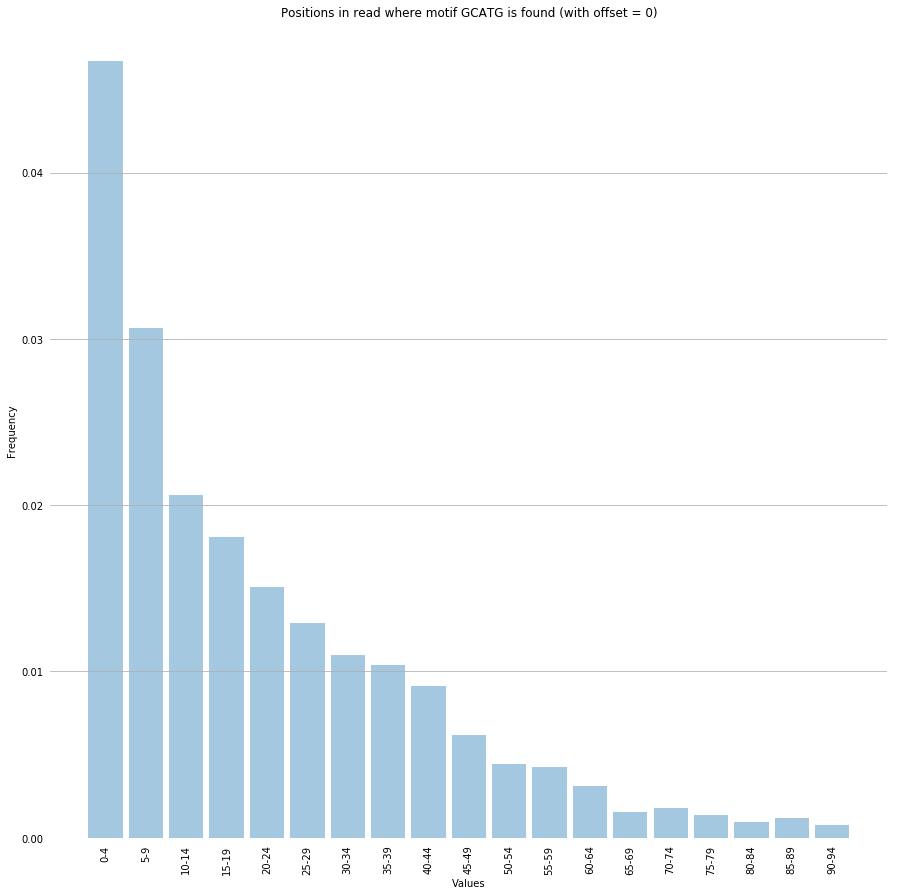

In [16]:
pos = [] # length will be the number of all OCCURRENCES OF MOTIF (can be more than peak num); contains positions where a motif was found. 
with open(os.path.join(output_dir, 'RBFOX2_peaks.fasta'), 'r') as f:
    for line in f:
        if line.startswith('>'):
            chrom, start, end, strand = record_id_to_coords(line[1:].rstrip())
        else:
            if strand == '+':
                pos += [p.start() for p in re.finditer(motif, line)]
            elif strand == '-':
                pos += [p.start() for p in re.finditer(motif, line)]
            else:
                print('strand not correct: [{}]'.format(strand))

x = pos
fig, ax = plt.subplots(figsize=(15,15))
make_hist(ax, x, bins=list(range(0, 100, 5)), extra_y=6)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
plt.title("Positions in read where motif {} is found (with offset = {})".format(motif, slop))
plt.show()

### Let's read a few sequences and check our work
- seqs_with_motif should be a list of SeqIO records containing a motif. 
- Let's print out a few sequences to ensure that we can find these motifs and that our work up until now is good. 

In [17]:
seqs_with_motif = []

with open(os.path.join(output_dir, 'RBFOX2_peaks.fasta'), 'r') as f:
    for record in SeqIO.parse(f, "fasta"):
        chrom, start, end, strand = record_id_to_coords(record.id)
        if strand == '+' and str(record.seq).upper().find(motif) != -1:
            seqs_with_motif.append(record)
        elif strand == '-' and str(record.seq).upper().find(motif) != -1:
            seqs_with_motif.append(record)
        else:
            assert strand == '+' or strand == '-'
        ### The following code is temporarily removed since I don't think we need to search for the reverse complement of the motif. ###
        # elif strand == '-' and str(record.seq).find(reverse_complement(motif)) != -1:
        #     if record.id == 'chr1:23411488-23411598(-)':
        #         print(len(seqs_with_motif), record.seq, str(record.seq).find(motif))
            
for record in seqs_with_motif[:5]:
    print(record.id, record.seq.upper(), record.seq.upper().find(motif))

chr7:99949578-99949663(+) TGGTGGTGGGTCATGCATGCTGGGGTGGCTCTCAGGTCCTCCCTGCTGGCTTCCCACTCCCAGGGGCTTTCTCCTCCCAGATTCC 14
chr7:76189536-76189625(+) CCTATTCTGAAATCCTCACTGGTTTCCCCCCACCCCACCCCTCATGTCACTCAGAGTAAACCCTAACTTCGCATGTGCCTGACAGGGTC 70
chr7:891283-891363(+) TACTTGCTGCATGAGCGCCCTTGGTTTCTCTGGGGTTGGGTCTGGGGGAAGTCCGGCTGCCTGAATGCCCGGTGCAGAGA 8
chr7:44086401-44086504(+) CTTCCTGTTGCATGTTGAATAAAGCCTAGACTCCTTGCCCTGCTGATGCCCTGCATGACCCAGAACCTACCACCCCTTTCATTTACCACACTGTGGCCACACC 9
chr7:76199656-76199721(+) TCTCTTGCATGTTTCAGGTATTTTTGCCATCTCAGGACTGAGAGGCCCTGGCAAACTGGCAGTTG 6


# Re-center genomic coordinates about the motif
- Coordinates are currently based on the peak location. 
- Let's modify the coordinates so they are centered around where the motif is.

In [18]:
def get_coords_centered_on_motif(record, motif, n):
    """ 
    Given a motif and a sequence, return genomic coordinates centered N bases around the motif.
    
    Regardless of strand, we're looking for the same motif although I wrote a code block to also 
    look for reverse complement motifs, if I need it. 
    
    """
    chrom, start, end, strand = record_id_to_coords(record.id)
    if strand == '+':
        # relative positions
        start_motif_pos = record.seq.upper().find(motif)
        end_motif_pos = start_motif_pos + len(motif)
        # actual genomic positions.
        motif_genome_start = start + start_motif_pos
        motif_genome_end = start + end_motif_pos 
        # if we wanted to add n bases on either side
        flank_genome_start = motif_genome_start - n
        flank_genome_end = motif_genome_end + n
    elif strand == '-':
        dna_seq = reverse_complement(record.seq.upper()) # Bedtools sequence returns the reverse complemented sequence.
        
        start_motif_pos = dna_seq.find(reverse_complement(motif))
        end_motif_pos = start_motif_pos + len(motif)
        
        motif_genome_start = start + start_motif_pos
        motif_genome_end = start + end_motif_pos 

        flank_genome_start = motif_genome_start - n
        flank_genome_end = motif_genome_end + n
    else:
        print("Strand error")
        return -1, -1
    if start_motif_pos == -1:
        return -1, -1
    return chrom, flank_genome_start, flank_genome_end, strand

### Let's check my work again

# Now we have coordinates centered around motifs within 3'UTR RBFOX2 peaks. Let's convert to bedtool objects (motif_centric_bedtoaol)
- seqs_with_motif -> motif_centric_bedtool
- save as *.motif_centric_coords.bed

In [19]:
def coords_to_bedtool(chrom, start, end, name, score, strand):
    """ Just returns bedtool intervals from gene coords. """
    return pybedtools.create_interval_from_list(
        [chrom, str(start), str(end), name, str(score), strand]
    )

bedtool = []
for record in seqs_with_motif:
    chrom, start, end, strand = get_coords_centered_on_motif(record, motif=motif, n=0)
    interval = coords_to_bedtool(chrom, start, end, record.id, "0", strand)
    bedtool.append(interval)

motif_centric_bedtool = pybedtools.BedTool(bedtool).sort()

# all coords should contain 'GCATG' or whatever the motif was specified before
motif_centric_bedtool.to_dataframe().head()

/home/bay001/anaconda2/envs/python3-essential/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)


,chrom,start,end,name,score,strand
0,chr1,781911,781916,chr1:781896-781968(+),0,+
1,chr1,790567,790572,chr1:790534-790625(+),0,+
2,chr1,790639,790644,chr1:790625-790698(+),0,+
3,chr1,790921,790926,chr1:790898-790934(+),0,+
4,chr1,791159,791164,chr1:791131-791181(+),0,+


# Check windows that contain more than one motif.
- If we notice that there is not any enrichment around regions surrounding the motif, we should remove regions that contain more than one motif. However in doing so, we end up filtering many peaks, so there is a tradeoff.
- to do this, we'll need to first generate a window centered around the within-peak motif
- then we will need to get teh associated sequences
- remove any sequence that has more than one occurrence of the motif
- convert filtered seqs back to a BED file for easier downstream analysis parsing
- because these regions are now slopped, I need to remove the slop to get back to the original coords (centered only around the motif)

In [20]:
# Define the size of the window surrounding the motif.
window_len = 600
window_slop = int(window_len/2)

In [21]:
def get_motif_loc_from_slopped_coords(chrom, start, end, motif, strand, window_slop):
    """ 
    I think I need this function to revert back to the original motif coords 
    (coords without the window slop). I do this because in the next cells I'll need
    to determine the distance of edits from these motifs, and to do this I'll need 
    to call bedtools closest() on the motif-centric coordinates. 
    *Note* Using "motif" param as just the name, not that important
    """
    return pybedtools.create_interval_from_list(
        [chrom, str(start + window_slop), str(end - window_slop), motif, '0', strand]
    )
    
motif_centric_bedtool_wflank = motif_centric_bedtool.slop(b=window_slop, genome='hg19')
motif_centric_sequences_wflank = motif_centric_bedtool_wflank.sequence(fi=hg19_fasta, s=True)

# save the temp file
with open(os.path.join(output_dir, 'RBFOX2_peaks_motif_centric_sequences_wflank.fasta'), 'w') as f:
    f.write(open(motif_centric_sequences_wflank.seqfn).read())

# open the temp file and look for multiple occurrences of the motif. Keep 
filtered_records = []

clustered = 0  # number of windows with more than one motif
unclustered = 0  # number of windows with exit 
all_records = 0

with open(os.path.join(output_dir, 'RBFOX2_peaks_motif_centric_sequences_wflank.fasta'), 'r') as f:
    for record in SeqIO.parse(f, "fasta"):
        all_records += 1
        pos = [p.start() for p in re.finditer(motif, str(record.seq).upper())]
        assert len(pos) > 0 # all sequences MUST have at least one motif.
        if len(pos) == 1: # just finds one occurrence of motif within the window
            filtered_records.append(record)
            unclustered += 1
        elif len(pos) > 1:
            clustered += 1
            
SeqIO.write(
    filtered_records, 
    os.path.join(
        output_dir, 
        'RBFOX2_peaks_motif_centric_sequences_wflank.filtered.fasta'
    ), 
    "fasta"
)

intervals = []
with open(os.path.join(output_dir, 'RBFOX2_peaks_motif_centric_sequences_wflank.fasta'), 'r') as f:
    for line in f:
        if line.startswith('>'):
            chrom, start, end, strand = record_id_to_coords(line[1:].rstrip())
            intervals.append(
                get_motif_loc_from_slopped_coords(
                    chrom, start, end, motif, strand, window_slop
                )
            )
filtered_motif_centric_bedtool = pybedtools.BedTool(intervals)

print(unclustered, clustered, all_records)

789 2063 2852


# Check a few regions to ensure correctness of the above

In [22]:
filtered_motif_centric_bedtool.to_dataframe().head(15)

/home/bay001/anaconda2/envs/python3-essential/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)


,chrom,start,end,name,score,strand
0,chr1,781911,781916,GCATG,0,+
1,chr1,790567,790572,GCATG,0,+
2,chr1,790639,790644,GCATG,0,+
3,chr1,790921,790926,GCATG,0,+
4,chr1,791159,791164,GCATG,0,+
5,chr1,885510,885515,GCATG,0,-
6,chr1,885560,885565,GCATG,0,-
7,chr1,885771,885776,GCATG,0,-
8,chr1,886090,886095,GCATG,0,-
9,chr1,888020,888025,GCATG,0,-


# Per Shashank's suggestion, try centering the analysis on the 'C' of the TGCATG motif. Makes the 0-overlap less ambiguous than performing analysis on the TGCATG motif itself.

In [23]:
filtered_motif_centric_bedtool = filtered_motif_centric_bedtool.to_dataframe()

pos_strand_filtered = filtered_motif_centric_bedtool[filtered_motif_centric_bedtool['strand']=='+']
neg_strand_filtered = filtered_motif_centric_bedtool[filtered_motif_centric_bedtool['strand']=='-']

# careful to do this in end first, start second. 
pos_strand_filtered['end'] = pos_strand_filtered['start'] + 2 
pos_strand_filtered['start'] = pos_strand_filtered['start'] + 1  # -> GCATG ("C" is the 1st 0-based position)
# pos_strand_filtered['end'] = pos_strand_filtered['start'] + 3 
# pos_strand_filtered['start'] = pos_strand_filtered['start'] + 2  # -> TGCATG ("C" is the 2nd 0-based position)

neg_strand_filtered['end'] = neg_strand_filtered['start'] + 4
neg_strand_filtered['start'] = neg_strand_filtered['start'] + 3  # -> CATGC ("G" is the 3rd 0-based position)

filtered_motif_centric_bedtool = pd.concat([pos_strand_filtered, neg_strand_filtered])

filtered_motif_centric_bedtool = pybedtools.BedTool.from_dataframe(filtered_motif_centric_bedtool).sort()

/home/bay001/anaconda2/envs/python3-essential/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/bay001/anaconda2/envs/python3-essential/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/bay001/anaconda2/envs/python3-essential/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [24]:
filtered_motif_centric_bedtool.to_dataframe().head(15)

/home/bay001/anaconda2/envs/python3-essential/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)


,chrom,start,end,name,score,strand
0,chr1,781912,781913,GCATG,0,+
1,chr1,790568,790569,GCATG,0,+
2,chr1,790640,790641,GCATG,0,+
3,chr1,790922,790923,GCATG,0,+
4,chr1,791160,791161,GCATG,0,+
5,chr1,885513,885514,GCATG,0,-
6,chr1,885563,885564,GCATG,0,-
7,chr1,885774,885775,GCATG,0,-
8,chr1,886093,886094,GCATG,0,-
9,chr1,888023,888024,GCATG,0,-


In [25]:
for interval in [
    ['chr1', '879726', '880131', 'negative-strand', '0', '-'],
    ['chr1', '2116316', '2116721', 'positive-strand', '0', '+'],
    ['chr1', '7840379', '7840784', 'positive-strand-filtered', '0', '+']
]:
    region, sequence, _ = open(
        pybedtools.BedTool(
            [pybedtools.create_interval_from_list(interval)]
        ).sequence(
            fi=hg19_fasta, s=True
        ).seqfn
    ).read().split('\n')
    print("{}\n{}".format(region, sequence.upper()))

>chr1:879726-880131(-)
GCTGGCCCAGGGGCCGGAGGACGAGCTGGAGGATCTGCAGCTCTCAGAGGACGACTGAGGCAGCCCATCTGGGGGGCCTGTAGGGGCTGCCGGGCTGGTGGCCAGTGTTTCCACCTCCCTGGCAGTCAGGCCTAGAGGCTGGCGTCTGTGCAGTTGGGGGAGGCAGTAGACACGGGACAGGCTTTATTATTTATTTTTCAGCATGAAAGACCAAACGTATCGAGAGCTGGGCTGGGCTGGGCTGGTGTGGCTGCTGAAGCCCCACAGCTGTGGGCTGCTGAAGTCAGCTCCGCGGGGGAGCTGACCCTGACGTCAGCAGACCGAGACCAGTCCCAGTTCCAGGGGGAGGCCTGCAGGCCCCTGGCCCCTTCCACCACCTCTGCCCTCCGTCTGCAGACCTCGTCC
>chr1:2116316-2116721(+)
GAACACACGGTCACCCCCCTCCCCCCTGCCACCTTTGCCCACAGGGATGCCATAAAGAGGATCGACCAGTCAGAGTTCGAAGGCTTTGAGTATATCAACCCATTATTGCTGTCCACCGAGGAGTCGGTGTGAGGCCGCGTGCGTCTCTGTCGTGGACACGCGTGATTGACCCTTTAACTGTATCCTTAACCACCGCATATGCATGCCAGGCTGGGCACGGCTCCGAGGGCGGCCAGGGACAGACGCTTGCGCCGAGACCGCAGAGGGAAGCGTCAGCGGGCGCTGCTGGGAGCAGAACAGTCCCTCACACCTGGGCCCGGGCAGGCCAGCTTCGTGCTGGAGGAACTTGCTGCTGTGCCTGCGTCGCGGCGGATCCGCGGGGACCCTGCCGAGGGGGCTGTCATG
>chr1:7840379-7840784(+)
TTGCCAAAAAGTTAAATACCGATAAAATGGCCTTAAGTGTATTCCTGACAGTTAAATTCAGAAACGTGCCAAATGGAACTCAAGGTGCCCCTTCAGAATTAAAATCATTACCTTG

# Now let's see how close editing sites are to each motif-centered peak

### First let's use a cutoff conf score defined here

In [26]:

# Define the "editing_sites" path at the beginning of the notebook
all_sites = pd.read_table(
    editing_sites, 
    names=['chrom','start','end','name','editfrac','strand']
)
all_sites['conf'] = all_sites['name'] # .apply(lambda x: float(x.split('|')[-1]))
all_sites = all_sites[['chrom','start','end','conf','editfrac','strand']]
sites = all_sites[all_sites['conf']>= RBFOX2_CONF]
print("Number of sites: {} -> {}".format(all_sites.shape[0], sites.shape[0]))
num_fox_sites = sites.shape[0]
all_sites.head()

/home/bay001/anaconda2/envs/python3-essential/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """


Number of sites: 403256 -> 197208


,chrom,start,end,conf,editfrac,strand
0,chr1,566364,566365,0.950990,"1,6",+
1,chr1,566444,566445,0.636185,"1,46",+
2,chr1,566668,566669,0.950990,"1,6",+
3,chr1,566713,566714,0.895338,"1,12",+
4,chr1,566722,566723,0.895338,"1,12",+


### Transform the filtered editing sites into a bedtool object

In [27]:
editing_sites_bedtool = pybedtools.BedTool.from_dataframe(sites).sort()

# Use Bedtools closest to determine which editing sites are closest to each peak (find closest editing sites with respect to the peak)
params used:
- s: stranded - only count features on the same strand.
- D: 'a' - Like -d, report the closest feature in B, and its distance to A. 'a' reports distance with respect to A. When A is on the - strand, "upstream" means B has a higher (start,stop)
- k: Report the k closest hits. Default is 1. If tieMode = "all", - all ties will still be reported.

I also filter out any peak with no closest hits (start is reported as -1) as well as any hit further than 150bp away. 

In [28]:
closest_real = filtered_motif_centric_bedtool.closest(editing_sites_bedtool, s=True, D='a', k=window_len, t='all').to_dataframe(
    names=[
        'peak_chrom',
        'peak_recentered_start',
        'peak_recentered_end',
        'peak_name',
        'peak_score',
        'peak_strand',
        'edit_chrom',
        'edit_start',
        'edit_end',
        'edit_cov_frac_conf',
        'edit_frac',
        'edit_strand',
        'distance'
    ]
)
print(closest_real.shape[0]) 
# Removes any edit that isn't closer than 'window_slop' away from the center of the motif. This is 300, 100nt beyond the window boundaries so that the counts don't just drop off immediately
closest_real = closest_real[(closest_real['edit_start']!=-1) & (np.abs(closest_real['distance']) <= window_slop)]

print(closest_real.shape[0]) 
closest_real.head()

/home/bay001/anaconda2/envs/python3-essential/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)


1711200
2568


,peak_chrom,peak_recentered_start,peak_recentered_end,peak_name,peak_score,peak_strand,edit_chrom,edit_start,edit_end,edit_cov_frac_conf,edit_frac,edit_strand,distance
600,chr1,790568,790569,GCATG,0,+,chr1,790609,790610,0.960596,"1,5",+,41
601,chr1,790568,790569,GCATG,0,+,chr1,790610,790611,0.960596,"1,5",+,42
602,chr1,790568,790569,GCATG,0,+,chr1,790617,790618,0.960596,"1,5",+,49
1200,chr1,790640,790641,GCATG,0,+,chr1,790617,790618,0.960596,"1,5",+,-23
1201,chr1,790640,790641,GCATG,0,+,chr1,790610,790611,0.960596,"1,5",+,-30


#### Prevents double counting edits where one edit may overlap multiple regions

In [29]:
_closest_real = closest_real[(closest_real['edit_start']!=-1) & (np.abs(closest_real['distance']) <= 200)]
_closest_real.drop_duplicates(['edit_chrom','edit_start','edit_end','edit_strand']).shape

(1751, 13)

#### If we, for some reason, need to know how many motifs contained an edit within 'window_slop' (200nt) 

In [30]:
_closest_real.drop_duplicates(['peak_chrom','peak_recentered_start','peak_recentered_end','peak_strand']).shape

(425, 13)

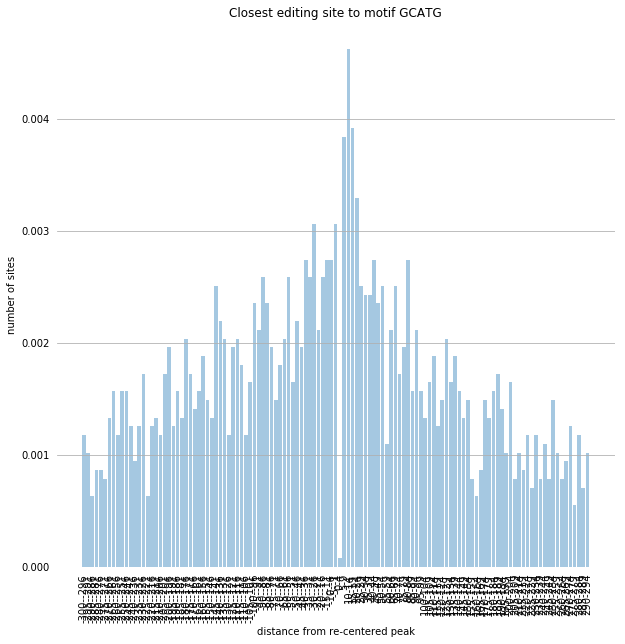

In [31]:
x = list(closest_real['distance'])
fig, ax = plt.subplots(figsize=(10,10))
make_hist(ax, x, bins=list(range(-window_slop, window_slop, 5)), extra_y=6)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_xlabel("distance from re-centered peak")
ax.set_ylabel("number of sites")
plt.title("Closest editing site to motif {}".format(motif))
plt.show()

# Let's zoom in and make sure we're not getting any edits on [G]C[ATG]
- 'C' is position 0

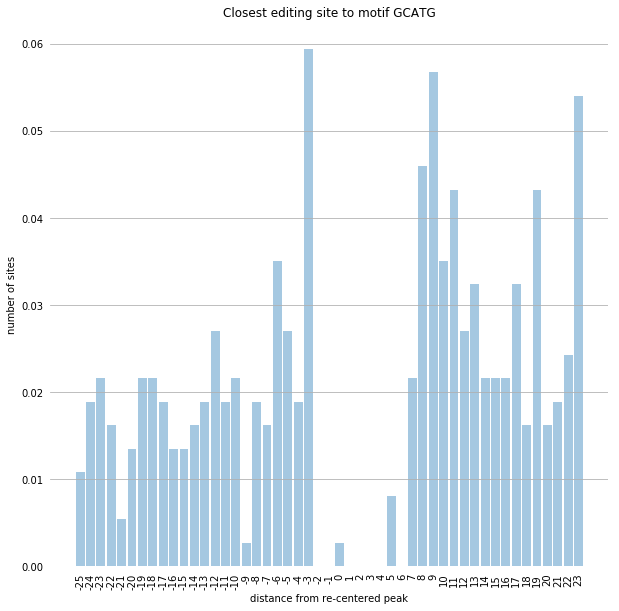

In [32]:
x = list(closest_real['distance'])
fig, ax = plt.subplots(figsize=(10,10))
make_hist(ax, x, bins=list(range(-25, 25, 1)), extra_y=6)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_xlabel("distance from re-centered peak")
ax.set_ylabel("number of sites")
plt.title("Closest editing site to motif {}".format(motif))
plt.show()

In [33]:
closest_real[closest_real['distance']==5]

,peak_chrom,peak_recentered_start,peak_recentered_end,peak_name,peak_score,peak_strand,edit_chrom,edit_start,edit_end,edit_cov_frac_conf,edit_frac,edit_strand,distance
679201,chr17,12908901,12908902,GCATG,0,-,chr17,12908896,12908897,0.960596,"1,5",-,5
1066200,chr20,62365603,62365604,GCATG,0,+,chr20,62365608,62365609,0.960596,"1,5",+,5
1680600,chrX,67752898,67752899,GCATG,0,+,chrX,67752903,67752904,0.963852,"2,31",+,5


# The "Dip" makes sense because I wouldn't expect editing to occur directly on the motif site itself. But there is some, so I'm going to check.

In [34]:
closest_real[(closest_real['distance'] < 4) & (closest_real['distance'] >= 0)].sort_values(by=['peak_recentered_start', 'distance'])

,peak_chrom,peak_recentered_start,peak_recentered_end,peak_name,peak_score,peak_strand,edit_chrom,edit_start,edit_end,edit_cov_frac_conf,edit_frac,edit_strand,distance
679200,chr17,12908901,12908902,GCATG,0,-,chr17,12908901,12908902,0.960596,"1,5",-,0


# Talk with Kris, a better background might be using the APOBEC-only editing sites
- we see a similar distribution between motif and random sites due to possible motifs in the random sites themselves. By eye, Kris sees the RBFOX motifs scattered quite frequently in the UTR region, both inside and outside the peak region.

In [35]:
# Define the "editing_sites" path at the beginning of the notebook
all_sites = pd.read_table(
    editing_sites_apobec_only, 
    names=['chrom','start','end','name','editfrac','strand']
)
all_sites['conf'] = all_sites['name'] # .apply(lambda x: float(x.split('|')[-1]))
all_sites = all_sites[['chrom','start','end','conf','editfrac','strand']]
sites = all_sites[all_sites['conf'] >= APOBEC_CONF]
print("Number of sites: {} -> {}".format(all_sites.shape[0], sites.shape[0]))
num_apo_sites = sites.shape[0]
sites.head()

Number of sites: 66380 -> 20550


/home/bay001/anaconda2/envs/python3-essential/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


,chrom,start,end,conf,editfrac,strand
0,chr1,324297,324298,0.994820,"2,12",+
1,chr1,327518,327519,0.950990,"1,6",+
3,chr1,564568,564569,0.950990,"1,6",+
4,chr1,566730,566731,0.913517,"1,10",+
5,chr1,567190,567191,1.000000,"22,23",+


In [36]:
editing_sites_bedtool = pybedtools.BedTool.from_dataframe(sites).sort()

In [37]:
closest_apobec_only_background = filtered_motif_centric_bedtool.closest(editing_sites_bedtool, s=True, D='a', k=window_slop, t='all').to_dataframe(
    names=[
        'peak_chrom',
        'peak_recentered_start',
        'peak_recentered_end',
        'peak_name',
        'peak_score',
        'peak_strand',
        'edit_chrom',
        'edit_start',
        'edit_end',
        'edit_cov_frac_conf',
        'edit_frac',
        'edit_strand',
        'distance'
    ]
)
print(closest_apobec_only_background.shape[0]) 
closest_apobec_only_background = closest_apobec_only_background[(closest_apobec_only_background['edit_start']!=-1) & (np.abs(closest_apobec_only_background['distance']) <= window_slop)]
print(closest_apobec_only_background.shape[0]) 


/home/bay001/anaconda2/envs/python3-essential/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)


832231
164


In [38]:
_closest_apobec_only_background = closest_apobec_only_background[(closest_apobec_only_background['edit_start']!=-1) & (np.abs(closest_apobec_only_background['distance']) <=200 )]
_closest_apobec_only_background.drop_duplicates(subset=['edit_chrom','edit_start','edit_end','edit_strand']).shape

(97, 13)

[41, 42, 49, -23, -30, -31, 162, 219, 23, 80, -145, -185, 7, 42, 295, 251, 22, 35, 37, 48, 50, -160, 16, 13, -58, -69, -79, -90, -98, -49, -60, -70, -81, -89, 298, -56, -15, -3, -5, 70, -125, 282, -86, 128, -164, 74, 298, -6, 125, 165, 7, -6, 22, 68, -74, -78, 181, -10, -19, -25, -34, 33, -173, 254, 294, 297, -44, -57, 67, -68, -99, 106, -115, -130, -150, -154, -204, 258, -188, -259, -291, 20, 24, 26, -36, -47, -129, -156, -180, -187, -205, -106, 51, 11, -27, 174, 74, -31, -39, 200, -12, -18, 34, 47, -91, -104, -150, -156, 274, 283, -6, 9, -18, -21, -24, -30, 42, -46, -51, 61, 87, -92, -93, -96, 99, -106, -123, 124, 128, -131, -139, -141, -144, -150, -155, -157, -167, 203, -204, 208, 211, 217, 229, 237, 241, 250, 274, 285, 104, 126, 186, -3, 22, 54, 21, -30, -63, -82, -105, -113, -184, 185, 252, -13, -19, -36, -56, -73, 17, 73, -3, -4, -10, -12, -18, -22, -27, 30, 51, 56, 63, 69, 75, 78, -91, 104, -113, -133, -135, -150, 152, -154, 157, -175, -180, -184, -203, 203, 225, -231, -242, -26

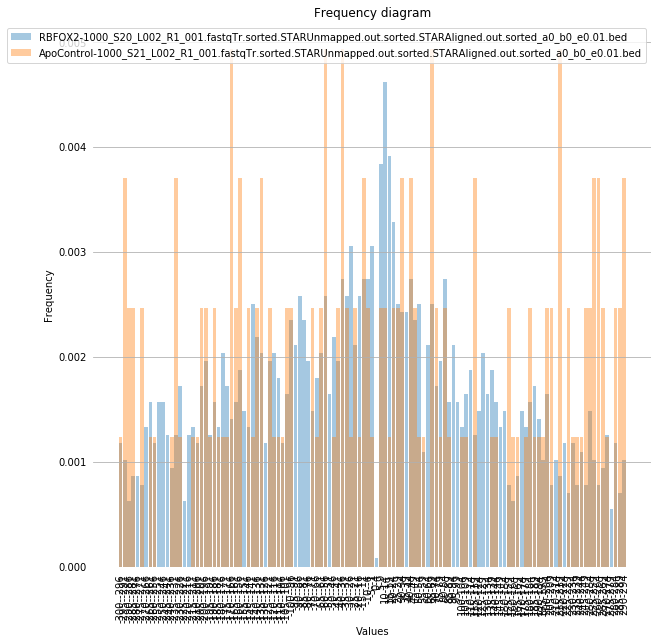

In [39]:
x = list(closest_real['distance'])
y = list(closest_apobec_only_background['distance'])
print(x, y)
fig, ax = plt.subplots(figsize=(10,10))
make_hist(ax, x, bins=list(range(-window_slop, window_slop, 5)), extra_y=6, label=os.path.basename(editing_sites))
make_hist(ax, y, bins=list(range(-window_slop, window_slop, 5)), extra_y=6, label=os.path.basename(editing_sites_apobec_only))
# ax.set_ylim(0, 0.05)
# ax.set_ylim(0, 200)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
plt.legend()
plt.show()
fig.savefig(os.path.join(output_dir, 'RBFOX2_and_APO-only_edits_near_{}_motifs_histogram.svg'.format(motif)))

/home/bay001/anaconda2/envs/python3-essential/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/bay001/anaconda2/envs/python3-essential/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


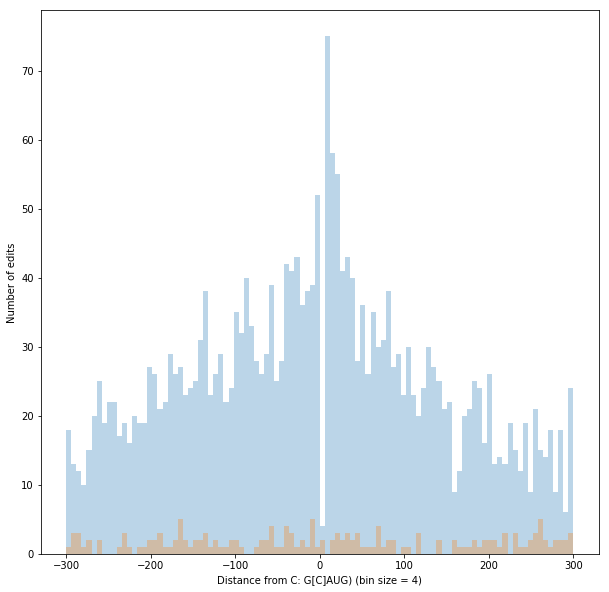

In [40]:
fig, ax = plt.subplots(figsize=(10, 10))
a = ax.hist(closest_real['distance'], bins=100, normed=False, alpha=0.3)
b = ax.hist(closest_apobec_only_background['distance'], bins=100, normed=False, alpha=0.3)
ax.set_xlabel('Distance from C: G[C]AUG) (bin size = 4)')
ax.set_ylabel('Number of edits')
fig.savefig(os.path.join(output_dir, 'RBFOX2_and_APO-only_edits_near_{}_motifs_histogram_unnormalized.svg'.format(motif)))

/home/bay001/anaconda2/envs/python3-essential/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/bay001/anaconda2/envs/python3-essential/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


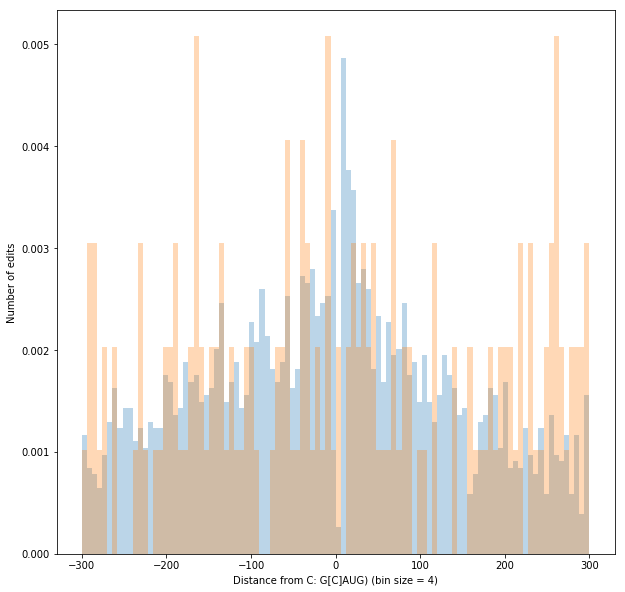

In [41]:
fig, ax = plt.subplots(figsize=(10, 10))
a = ax.hist(closest_real['distance'], bins=100, normed=True, alpha=0.3)
b = ax.hist(closest_apobec_only_background['distance'], bins=100, normed=True, alpha=0.3)
ax.set_xlabel('Distance from C: G[C]AUG) (bin size = 4)')
ax.set_ylabel('Number of edits')
fig.savefig(os.path.join(output_dir, 'RBFOX2_and_APO-only_edits_near_{}_motifs_histogram_unnormalized.svg'.format(motif)))

# Let's zoom in and make sure we're not getting any edits on [G]C[ATG]
- 'C' is position 0

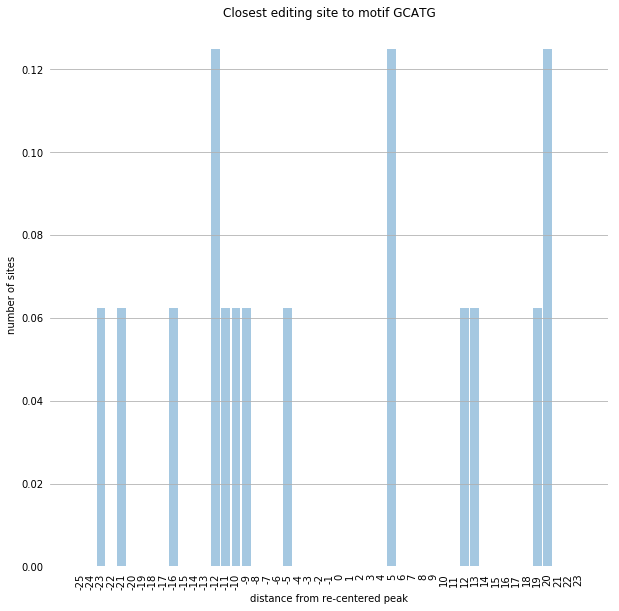

In [42]:
x = list(closest_apobec_only_background['distance'])
fig, ax = plt.subplots(figsize=(10,10))
make_hist(ax, x, bins=list(range(-25, 25, 1)), extra_y=6)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_xlabel("distance from re-centered peak")
ax.set_ylabel("number of sites")
plt.title("Closest editing site to motif {}".format(motif))
plt.show()

/home/bay001/anaconda2/envs/python3-essential/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/bay001/anaconda2/envs/python3-essential/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


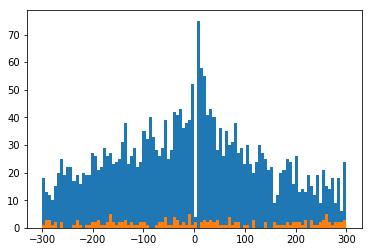

In [43]:
a, bins, patches = plt.hist(list(closest_real['distance']), bins=100, normed=False)
b, bins, patches = plt.hist(list(closest_apobec_only_background['distance']), bins=100, normed=False)
h = pd.DataFrame({
    'real':a+1,
    'bg':b+1
})
h['fold'] = h['real'].div(h['bg'])
h['l2real'] = np.log2(h['real'])
h['l2bg'] = np.log2(h['bg'])
h['l2fold'] = np.log2(h['fold'])

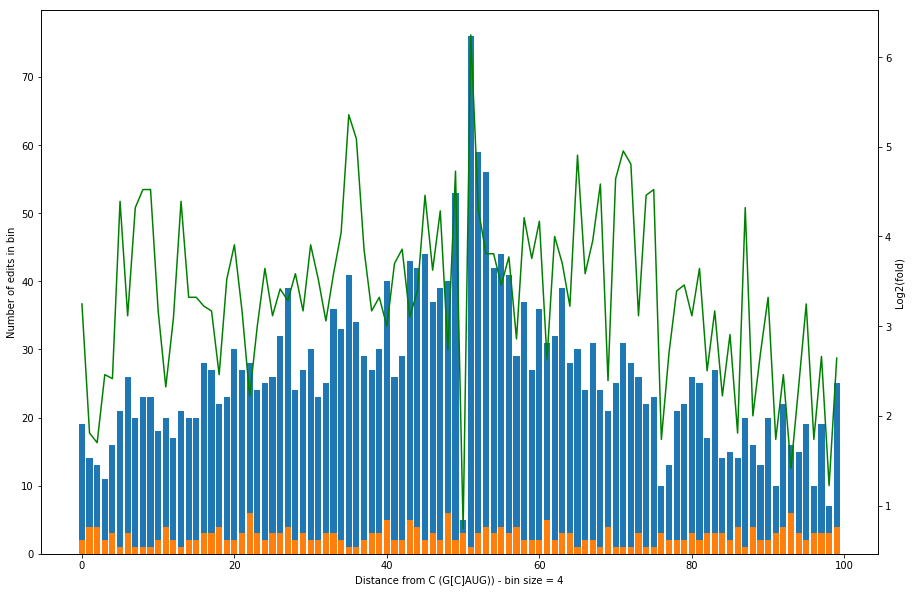

In [44]:
fig, ax1 = plt.subplots(figsize=(15, 10))
ax1.bar(h.index, h['real'])
ax1.bar(h.index, h['bg'])

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(h.index, h['l2fold'], color='green')
ax1.set_ylabel("Number of edits in bin")
ax2.set_ylabel("Log2(fold)")
ax1.set_xlabel("Distance from C (G[C]AUG)) - bin size = 4")
fig.savefig(os.path.join(output_dir, 'RBFOX2_and_APO-only_edits_near_{}_motifs_histogram_unnormalized.svg'.format(motif)))

In [45]:
num_fox_sites/num_apo_sites

9.596496350364964

<BarContainer object of 100 artists>

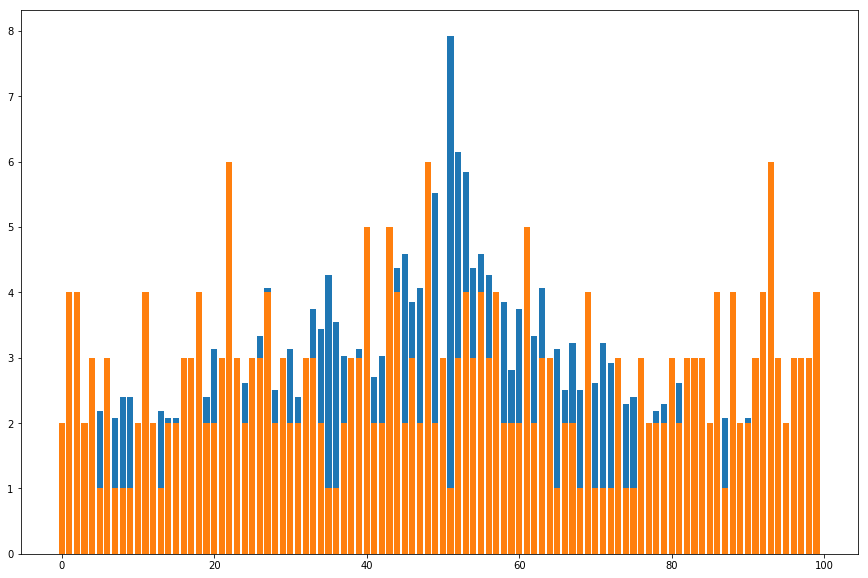

In [46]:
h['scaledreal'] = h['real']/(num_fox_sites/num_apo_sites)
h['scaledbg'] = h['bg']
fig, ax1 = plt.subplots(figsize=(15, 10))
ax1.bar(h.index, h['scaledreal'])
ax1.bar(h.index, h['scaledbg'])

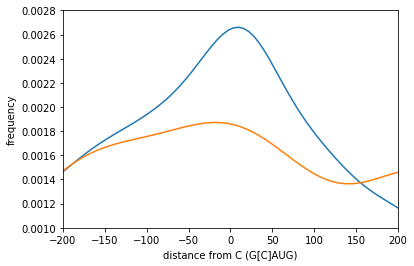

In [47]:
fig, ax = plt.subplots()
sns.distplot(closest_real['distance'], ax=ax, bins=500, hist=False)
sns.distplot(closest_apobec_only_background['distance'], ax=ax, bins=500, hist=False)
ax.set_xlim(-200, 200)
ax.set_ylabel('frequency')
ax.set_xlabel('distance from C (G[C]AUG)')
ax.set_ylim(0.001, 0.0028)
fig.savefig(os.path.join(output_dir, 'RBFOX2_and_APO-only_edits_near_{}_motifs_histogram_normalized_nohist_wsmoothed_line.svg'.format(motif)))

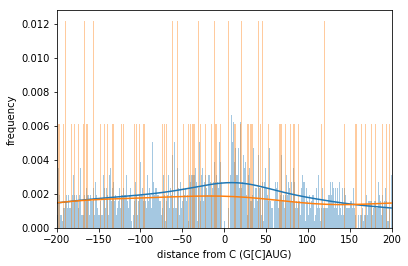

In [48]:
fig, ax = plt.subplots()
sns.distplot(closest_real['distance'], ax=ax, bins=600, hist=True)
sns.distplot(closest_apobec_only_background['distance'], ax=ax, bins=600, hist=True)
ax.set_xlim(-200, 200)
ax.set_ylabel('frequency')
ax.set_xlabel('distance from C (G[C]AUG)')
fig.savefig(os.path.join(output_dir, 'RBFOX2_and_APO-only_edits_near_{}_motifs_histogram_unnormalized_hist_wsmoothed_line.svg'.format(motif)))